In [1]:
from yamlscript_histdata import histdata_parser
from plot_classes import *
import numpy as np
import logging

In [2]:
df1, df2 = histdata_parser('CR_ttc_prefit.yaml')

histdata_parser ran in 772 ms.


In [7]:
df1

Yield
Samples tH                    [0.6777518379661686, 0.48202515103252475, 0.32...
        tWH                   [0.8611041195955744, 0.6849249457636786, 0.565...
        t#bar{t} + #geq1b     [1733.5952230273672, 1459.7220791327006, 1243....
        t#bar{t} + #geq1c     [1030.6650788589109, 1121.9675875571738, 1081....
        t#bar{t} + light      [1812.3554490930073, 1868.11989264379, 2284.18...
        t#bar{t} + H          [48.60518250639442, 40.04067687374472, 37.1956...
        t#bar{t} + Z          [26.39513222502811, 25.891754372557813, 23.170...
        t#bar{t} + W          [9.097638901211637, 9.221123801814636, 9.66502...
        tZq                   [3.0064648700008876, 2.4274298712699505, 1.887...
        tWZ                   [0.04788054892440356, 0.09976182831975486, 0.1...
        Single top Wt         [175.14497458907522, 148.07426668913155, 121.2...
        Single top t-channel  [60.565403275077784, 52.22631627470051, 33.653...
        Single top s-channel  [5.066621098451062, 2.918603468951397, 3.05051...
        W+jets                [77.94189126565779, 69.54620984482469, 53.5506...
        Z+jets                [15.871487030187941, 11.83468536999561, 8.4767...
        VV                    [6.323578172776456, 4.3221632420960905, 3.2804...
        other Higgs           [9.9999775265841e-07, 0.7665413752105269, 0.75...
        Rare top              [2.836732332314187, 2.9287473492684235, 2.3056...
        Non-prompt            [84.95362873515114, 76.8663441981189, 82.05425...
Total   Yield                 [5094.011223487095, 4898.141133990464, 4989.95...
        UncertaintyUp         [827.5826665452911, 805.426846012266, 826.1614...
        UncertaintyDown       [-827.5826665452911, -805.426846012266, -826.1...
Data    Yield                 [5417, 5168, 5474, 5419, 5314, 5398, 5337, 544...

In [3]:
dflist          = df1.loc[['Samples']]
hist_list       = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
histlist_edges  = df2.loc[['BinEdges'],0][0]
histlist_labels = ['$' + x.replace('#', '\\') + '$' for x in reversed(dflist.index.get_level_values(1).tolist())]
total_yield     = df1.loc[['Total'],'Yield'][0]
data_yield      = df1.loc[['Data'],'Yield'][0]
total_errup     = df1.loc[['Total'],'Yield'][1]
total_errdown   = df1.loc[['Total'],'Yield'][2]
xaxis_label     = '$' + df2.loc[['XaxisLabel'], 0][0].replace('#', '\\') + '$'
test1 = df1.iloc[0,0]

In [4]:
from plot_classes import EmptyPlot


class RatioPlot(EmptyPlot):
    
    
    def __init__(self, samples=[], data=[], ratio=[], stack=False, spacing=0, stretch=4, rcp_kw={}, **kwargs):
        
        super().__init__(layout=(2,1), **kwargs)
        
        # set default rcParams for the plot
        self.rcp_dict = {
            'legend.handletextpad': 1.15,
            'legend.columnspacing': 0.5,
            'legend.labelspacing' : 2,
            'legend.markerscale'  : 1.2,
            'xaxis.labellocation' : 'right', # location of x label w.r.t. x axis
            'yaxis.labellocation' : 'top', # location of y label w.r.t. y axis
            'axes.labelpad'       : 1, # distance of axis label from axis tick labels
            'axes.titlesize'      : 15, # master title font size
            'font.size'           : 10, # x, y label AND ticks label AND legend font size
            'lines.linewidth'     : 1,
        }
        
        # update dict if user has passed any rcParam values in the constructor
        self.rcp_dict.update({k: v for k, v in rcp_kw.items() if k in mpl.rcParams})
        
        # set parameters
        self.config_rcParams(self.rcp_dict)
        
        """
        Set default error histogram parameters. These are kwargs for matplotlib.ax.stairs()
        """
        self.errhist_dict = {
            'color'   : 'k',
            'alpha'   : 0.3,
            'hatch'   : '///',
        }
        
        """
        Set default plot histogram parameters. These are kwargs for matplotlib.ax.stairs()
        """
        self.histbins_dict = {
            'edgecolor': 'k',
            'facecolor': 'lime',
        }
        
        """
        Set default scatter plot parameters. These are kwargs for matplotlib.ax.errorbar()
        """
        self.scatter_dict = {
            'color': 'k',
            'markersize': self.rcp_dict['font.size'],
        }
        
        self.samples  = samples
        self.scatters = data
        self.ratio    = ratio
        self.is_stack = stack

        self.samples_dict = {}
        self.histos_dict = {}
        self.data_dict = {}
        
        self.check_input()        
        self.store_data()
            
        # bool if user put a custom y limits for bot plot
        self.custom_ylims = False
        
        # create plot figure and subplots
        self.create_canvas()
        self.make_grid(hspace=spacing, height_ratios=[stretch,1])
        self.mainax = self.make_subplot(0, 1, 0, 1)
        self.botax  = self.make_subplot(1, 2, 0, 1)
        
        # create list for colors of stack plot
        if self.is_stack:
            self.set_stack_color()
    
    
    def check_input(self):
        """
        Check datatype of the input objects
        """
        
        self.is_obj_bh   = False
        self.is_obj_pd   = False

        if self.samples:
            
            for samplename in self.samples:
                try:
                    with open(f"{samplename}.pkl", 'rb') as file:
                        obj = pickle.load(file)
                        
                        # check whether input is bh, pandas df or else
                        if isinstance(obj, bh.Histogram):
                            self.is_obj_bh = True
                        elif isinstance(obj, pd.core.frame.DataFrame):
                            self.is_obj_pd = True
                        else:
                            pass
                        
                        # store input into dictionary
                        self.samples_dict[samplename] = obj

                except:
                    logging.error(f"There is no file named {samplename} containing a histogram")
            
            if self.is_obj_bh and self.is_obj_pd:
                logging.error("All samples must be of the same type.")
            
            # check if given data (scatter) variables are present in samples
            if self.scatters:
                for scatter in self.scatters:
                    if scatter not in self.samples:
                        logging.error(f"There is no variable named {scatter} in Samples.")
            
            # check if given ratio variables are present in samples 
            if self.ratio:
                for name in self.ratio:
                    if name not in self.samples:
                        logging.error(f"There is no Sample named {name} to compute ratio plot.")
                    else:
                        break
                
            elif not self.ratio:
                logging.error("Please provide two Samples that will produce the ratio plot.")
            
        else:
            logging.error("Enter a non-empty list of samples to plot.")

        
    def store_data(self):
                
        if self.is_obj_bh:
            
            # for now, this assumes all samples have same dim and length (should check for this)
            # thus, take the first sample to retrieve general info
            _first_sample = self.samples_dict[next(iter(self.samples_dict))]
            # self.dim = first_sample.rank # .rank gives attribute error, think it's a bug
            self.datasize, = _first_sample.axes.size
            
            self.numerator = self.samples_dict[self.ratio[0]]
            self.denominator = self.samples_dict[self.ratio[1]]
            
            # calculate and store ratio values of specified samples
            self.ratiovalues = []
            for i in range(self.datasize):
                if self.denominator.values()[i] != 0: # avoid diviging by zero
                    self.ratiovalues.append(self.numerator.values()[i] / self.denominator.values()[i])
                else:
                    self.ratiovalues.append(0)
            
            self.histbin_labels = {}
            self.datapoints_labels = {}
            
            for samplename in self.samples:
                sample = self.samples_dict[samplename] # sample is a bh, samplename is a string
                
                # get and store metadata of bh
                _metadata, = sample.axes.metadata
                if samplename not in self.scatters:
                    self.histbin_labels[samplename] = _metadata
                    # also append samples that will be plotted as histograms
                    self.histos_dict[samplename] = sample
                else:
                    self.datapoints_labels[samplename] = _metadata
                    # also append samples that will be plotte as scatter points
                    self.data_dict[samplename] = sample

            # again, not checking whether all bh have same edges
            self.edges, = _first_sample.axes.edges
            
#         elif not self.is_stack and self.is_obj_bh:
#             self.histlistedges = [self.active_data.axes.edges[0][i] for i in range(len(self.active_data.axes.edges[0]))]
#             (self.histlistlabels,) = self.active_data.axes.metadata
#             self.histlisttotal = self.data_container[0][0].values()
#             self.histlistdata = self.data_container[0][1].values()
        
        else:
            ### these should be retrived internally from filled object ---------------------
            self.dflist          = dflist
            self.histlistedges   = histlist_edges
            self.histlisttotal   = total_yield
            self.histlistdata    = data_yield
            self.histlistlabels  = histlist_labels
            self.histlisterrup   = total_errup
            self.histlisterrdown = total_errdown
            # the lower part in the ratio plot is the data divided by the total hist cont
            self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
            ### ----------------------------------------------------------------------------

        
    def set_stack_color(self, colormap='viridis', reverse=False):
        """ 
        Create custom color map for stack histogram
        """
        
        clist = []
        n = len(self.histos_dict)
        pct_max, pct_min = 95, 5 # max and min percentile of color ramp
        cmap = mpl.cm.get_cmap(colormap)
        
        # list of values between 0.00 and 1.00; length equals length of data source
        sequence = list(i/100 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
        
        # reverse if required
        if reverse:
            sequence = reversed(sequence)
        
        # create list of colors
        for i in sequence:
            color = cmap(i) 
            clist.append(color)
        
        self.stack_colorlist = clist
        self.histbins_dict['facecolor'] = self.stack_colorlist
        
        
    def scatterdata_plotter(self, ax, stackdata=None, bins=None):
        """
        Plots data scatter points using mplhep function with argument histtype='errorbar'
        """
                    
        if self.is_obj_bh:
            if stackdata:
                hep.histplot(stackdata, bins=bins, ax=ax, histtype='errorbar', label=list(self.datapoints_labels.values()),
                             **self.scatter_dict)
            else:
                for dataname, data in self.data_dict.items():                    
                    hep.histplot(data, ax=ax, histtype='errorbar', label=self.datapoints_labels[dataname], yerr=False, 
                                 **self.scatter_dict)
        elif self.is_obj_pd:
            pass

        
    def histbins_plotter(self, ax, stackdata=None, bins=None, baseline=0):
        """
        Plots histogram bins using mplhep function
        """
        
        if self.is_obj_bh:
            if stackdata:
                hep.histplot(stackdata, bins=bins, ax=ax, histtype='fill', stack=self.is_stack, 
                             label=list(self.histbin_labels.values()), baseline=baseline, edgecolor='k')#, **self.histbins_dict)
            else:
                for histoname, histo in self.histos_dict.items():
                    hep.histplot(histo, ax=ax, histtype='fill', label=self.histbin_labels[histoname], yerr=False)#, **self.histbins_dict)
        elif self.is_obj_pd:
            pass
        
        
    def ratiovalues_plotter(self, ax):
        """
        Plots ratio values for bot plot
        """
        
        # use scatterdata_plotter() if numerator was specified to be a scatter data plot
        if self.ratio[0] in self.scatters:
            self.scatterdata_plotter(ax, self.ratiovalues, self.edges)
        else:
            self.histbins_plotter(ax, self.ratiovalues, self.edges, 1)
        
        
    def set_mainax(self):
        """
        Main plot
        """
        
        # hist plot
        if self.is_stack:
            # create list of bh objects to stack
            bh_list = [i for i in self.histos_dict.values()]
            self.histbins_plotter(self.mainax, bh_list)
        else:            
            self.histbins_plotter(self.mainax)
        
        # data scatter points
        if self.scatters:
            self.scatterdata_plotter(self.mainax)
                  
        # adjust ticks
        self.mainax.tick_params(
            direction='in', length=10, bottom=True, top=True, left=True, right=True, labelsize=self.rcp_dict['font.size']
        )
        self.mainax.tick_params(
            direction='in', length=5, bottom=True, top=True, left=True, right=True, which='minor'
        )
        
        # show full numbers without scientific notation
        self.mainax.ticklabel_format(style='plain')
        
        # set x axis ticks
        self.mainax.set_xticks(self.auto_xticks())
        self.mainax.set_xticklabels([]) # suppress x tick labels
        
        # add atlas logo and text
        self.set_explabel(self.mainax)
        
        # set legend
        self.set_legend()

        
    def set_botax(self):

        # ratio scatter data
        self.ratiovalues_plotter(self.botax)
        
        # adjust ticks
        self.botax.tick_params(direction='in', length=10, bottom=True, top=True, left=True, right=True,
                               labelsize=self.rcp_dict['font.size'])
        self.botax.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        
        self.botax.set_xticks(self.auto_xticks())
        
        # draw horizontal line at y=1
        self.botax.axhline(1, color='k', linestyle='--')

        if self.custom_ylims:
            self.botax.set_ylim(self.ylims)
            self.set_bot_yticks()
        
        
    def ratio_plot(self):
        
        self.set_mainax()
        self.set_botax()
        
        # # errors
        # if self.is_errplot:
        #     self.plot_errors()
        
        # set master title
        self.mainax.set_title(self.master_title, fontsize=self.rcp_dict['axes.titlesize'])
        
        
    def set_bot_yticks(self):
                
        self.botax.set_yticks(self.ybotrange)
        self.botax.set_yticklabels(self.ybotlabels, fontsize=self.rcp_dict['font.size'])
    
    
    def auto_xticks(self):
        # need to make this automatic
        
        nticks = 11
        xticks = np.linspace(self.edges[0], self.edges[-1], nticks)
        
        return xticks
        
        
    def make_baseline(self, errs):
        """
        Create baseline for error histogram bins
        """
        
        return [self.histlisttotal[i] + errs[i] for i in range(len(self.histlisttotal))]
    
    
    def make_ratioerrs(self, errs):
        """
        Create ratio error values
        """
        
        return [(self.histlisttotal[i] + errs[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
            
        
    def plot_errors(self, label='Uncertainty', **errors_kw):
        """
        Callable by user to change error histogram parameters for both main and bot plots
        """

        # update user input
        self.errhist_dict.update(errors_kw)
        
        # mainax
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, baseline=self.make_baseline(self.histlisterrup),
                           label=label, **self.errhist_dict)
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, baseline=self.make_baseline(self.histlisterrdown),
                           **self.errhist_dict)
        # botax
        self.botax.stairs(self.make_ratioerrs(self.histlisterrup), edges=self.histlistedges,
                          baseline=1, **self.errhist_dict)
        self.botax.stairs(self.make_ratioerrs(self.histlisterrdown), edges=self.histlistedges, 
                          baseline=1, **self.errhist_dict)

        
    def set_legend(self):
        """
        Create legend for main plot
        """
        
        # should make ncol be detected automatically
        self.mainax.legend(ncol=2, handlelength=mpl.rcParams['legend.handleheight']+0.04, fontsize=self.rcp_dict['font.size'])
        
        # scale ylim automatically for optimal legend placement
        # hep.plot.yscale_legend(ax=self.mainax) # sometimes this gives random errors with stack plot
        
        # sort legend entries
        hep.sort_legend(self.mainax)
        
        
    def set_bot_yaxis(self, ylims, step, edges=True):
        """
        Allow user to manually change the bot y axis limits, which can often
        overlap with various other plot elements. If edges is set to False,
        the first and last ticks will be omitted to make space in the plot.
        """
        
        self.custom_ylims = True
        
        self.ylims = ylims
        self.ystep = step
        self.ybotrange = np.arange(ylims[0], ylims[-1]+step, step)
        
        # check if any tick label would have non zero decimal places,
        # if so, leave zeros for all other tick labels as well
        # if not, remove all decimal zeros from tick labels
        temprange = [f'{x:.2f}' for x in self.ybotrange]
        need1 = False
        need2 = False
        
        for num in temprange[1:-1]:
            decimals = num.split('.')[1]
            d1 = decimals[0]
            d2 = decimals[1]
            
            if d2 != '0':
                need2 = True
                break
            if d1 != '0':
                need1 = True
            
        if need2:
            self.ybotlabels = [f'{x:.2f}' for x in self.ybotrange]
        elif need1:
            self.ybotlabels = [f'{x:.1f}' for x in self.ybotrange]
        else:
            self.ybotlabels = [f'{x:.0f}' for x in self.ybotrange]            
        
        if not edges:
            self.ybotlabels[0] = ''
            self.ybotlabels[-1] = ''
        
        
    def axes_labels(self, fontsize, labelpad=5, **titles_kw):
        """
        Set axis labels (also called titles here) according to user input
        """
        
        self.fill_titlesdict(**titles_kw)
        self.set_xtitles(self.botax, 'xbot', fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.mainax, 'ymain', fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.botax, 'ybot', fontsize=fontsize, labelpad=labelpad)
    
    
    """
    ========================================================================================
    Public functions
    ========================================================================================
    """
    
    
    def ratio_options(self, shape='', ylims=[], ystep=None, ytickedges=True, grid=''):
        
        
        pass
    
    
    def fontsize_options(self):
        
        
        pass
    
    
    def figure_options(self):
        
        
        pass

        
    def create(self, save_name='', dpi=1000):
        
        self.ratio_plot()
        
        if save_name:
            self.saveimage(save_name, dpi)

ERROR:root:There is no file named bh1 containing a histogram
ERROR:root:There is no file named bh2 containing a histogram
ERROR:root:There is no file named bh3 containing a histogram
ERROR:root:There is no file named bh4 containing a histogram


AttributeError: 'RatioPlot' object has no attribute 'fill_titlesdict'

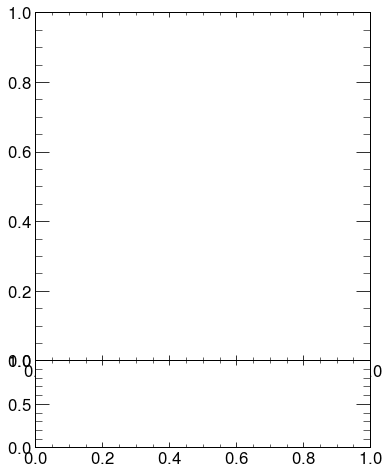

In [5]:
my_dict={
    'axes.titlesize': 20,
    'font.size': 10
}

plot = RatioPlot(samples=['bh1', 'bh2', 'bh3', 'bh4'], ratio=['bh3', 'bh1'], stack=False,
                 size=(6,8), spacing=0, title='Master Title', rcp_kw=my_dict)
plot.set_bot_yaxis([0, 3], 0.5, edges=False)
plot.axes_labels(15, ymain='Events', xbot='xtitle')
plot.set_stack_color(colormap='plasma', reverse=True)
plot.create()